## 5 - Modeling
> Explain Step

### 5.0 - Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [2]:
plt.style.use('seaborn-whitegrid')

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

### 5.1 - Read in Data

In [6]:
df = pd.read_csv('../clean_data/modeling2.csv')

In [7]:
df = df.loc[pd.DatetimeIndex(df['release_date']).year > 2012].copy()

In [8]:
df.head(1)

,company,security,gics_sector,gics_sub_industry,release_date,length_corpus,items,stock_change,index_change,normalized_change,vix,hist_week,hist_month,hist_quarter,hist_year,movement,processed_text
0,CSCO,Cisco Systems,Information Technology,Communications Equipment,2019-08-22 16:35:32,337,['Item8.01'],-0.005812,-0.004064,-0.001747,16.68,0.054486,-0.138644,-0.089602,0.059757,neutral,form 8-k united state security exchange commis...


In [9]:
df.shape

(43749, 17)

In [10]:
df.isnull().sum().sum()

0

### 5.2 - Create numerical `Target` Column

In [11]:
df['target'] = df['movement'].map(lambda x: 2 if x == 'up' else (1 if x == 'neutral' else 0))

In [12]:
df.isnull().sum().sum()

0

#### MLB Items

In [13]:
import ast
def eval_literal(list_words):
    try:
        return ast.literal_eval(list_words)  
    except ValueError:
        return ast.literal_eval(str(list_words))  

In [14]:
# Items from list of strings to literal - ''
df['items'] = df['items'].progress_map(eval_literal)

In [15]:
mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df['items']), columns=mlb.classes_,), sort=False, how="left")

In [16]:
df.head(1)

,company,security,gics_sector,gics_sub_industry,release_date,length_corpus,items,stock_change,index_change,normalized_change,vix,hist_week,hist_month,hist_quarter,hist_year,movement,processed_text,target,Item0.06,Item05.07,Item1.01,Item1.02,Item1.03,Item1.04,Item2.01,Item2.02,Item2.03,Item2.04,Item2.05,Item2.06,Item3.01,Item3.02,Item3.03,Item3.04,Item4.01,Item4.02,Item4.04,Item5.01,Item5.02,Item5.03,Item5.04,Item5.05,Item5.07,Item5.08,Item5.10,Item6.01,Item6.10,Item7.01,Item8.01,Item9.01
0,CSCO,Cisco Systems,Information Technology,Communications Equipment,2019-08-22 16:35:32,337,[Item8.01],-0.005812,-0.004064,-0.001747,16.68,0.054486,-0.138644,-0.089602,0.059757,neutral,form 8-k united state security exchange commis...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
df.isnull().sum().sum()

321312

In [18]:
df.drop(columns=['items'], inplace=True)

In [19]:
df.isnull().sum().sum()

321312

In [20]:
df.fillna(0, inplace=True)

#### Get Dummies `gics_sector` and `gics_sub_industry` - to Modeling

In [21]:
df = pd.get_dummies(df, columns=['gics_sector', 'gics_sub_industry'], drop_first=True)

In [22]:
df.head(1)

,company,security,release_date,length_corpus,stock_change,index_change,normalized_change,vix,hist_week,hist_month,hist_quarter,hist_year,movement,processed_text,target,Item0.06,Item05.07,Item1.01,Item1.02,Item1.03,Item1.04,Item2.01,Item2.02,Item2.03,Item2.04,Item2.05,Item2.06,Item3.01,Item3.02,Item3.03,Item3.04,Item4.01,Item4.02,Item4.04,Item5.01,Item5.02,Item5.03,Item5.04,Item5.05,Item5.07,Item5.08,Item5.10,Item6.01,Item6.10,Item7.01,Item8.01,Item9.01,gics_sector_Consumer Discretionary,gics_sector_Consumer Staples,gics_sector_Energy,gics_sector_Financials,gics_sector_Health Care,gics_sector_Industrials,gics_sector_Information Technology,gics_sector_Materials,gics_sector_Real Estate,gics_sector_Utilities,gics_sub_industry_Aerospace & Defense,gics_sub_industry_Agricultural & Farm Machinery,gics_sub_industry_Agricultural Products,gics_sub_industry_Air Freight & Logistics,gics_sub_industry_Airlines,gics_sub_industry_Apparel Retail,"gics_sub_industry_Apparel, Accessories & Luxury Goods",gics_sub_industry_Application Software,gics_sub_industry_Asset Management & Custody Banks,gics_sub_industry_Auto Parts & Equipment,gics_sub_industry_Automobile Manufacturers,gics_sub_industry_Automotive Retail,gics_sub_industry_Biotechnology,gics_sub_industry_Brewers,gics_sub_industry_Broadcasting,gics_sub_industry_Building Products,gics_sub_industry_Cable & Satellite,gics_sub_industry_Casinos & Gaming,gics_sub_industry_Communications Equipment,gics_sub_industry_Computer & Electronics Retail,gics_sub_industry_Construction & Engineering,gics_sub_industry_Construction Machinery & Heavy Trucks,gics_sub_industry_Construction Materials,gics_sub_industry_Consumer Electronics,gics_sub_industry_Consumer Finance,gics_sub_industry_Copper,gics_sub_industry_Data Processing & Outsourced Services,gics_sub_industry_Department Stores,gics_sub_industry_Distillers & Vintners,gics_sub_industry_Distributors,gics_sub_industry_Diversified Banks,gics_sub_industry_Diversified Chemicals,gics_sub_industry_Diversified Support Services,gics_sub_industry_Drug Retail,gics_sub_industry_Electric Utilities,gics_sub_industry_Electrical Components & Equipment,gics_sub_industry_Electronic Components,gics_sub_industry_Electronic Equipment & Instruments,gics_sub_industry_Electronic Manufacturing Services,gics_sub_industry_Environmental & Facilities Services,gics_sub_industry_Fertilizers & Agricultural Chemicals,gics_sub_industry_Financial Exchanges & Data,gics_sub_industry_Food Distributors,gics_sub_industry_Food Retail,gics_sub_industry_Gas Utilities,gics_sub_industry_General Merchandise Stores,gics_sub_industry_Gold,gics_sub_industry_Health Care Distributors,gics_sub_industry_Health Care Equipment,gics_sub_industry_Health Care Facilities,gics_sub_industry_Health Care REITs,gics_sub_industry_Health Care Services,gics_sub_industry_Health Care Supplies,gics_sub_industry_Health Care Technology,gics_sub_industry_Home Furnishings,gics_sub_industry_Home Improvement Retail,gics_sub_industry_Homebuilding,gics_sub_industry_Hotel & Resort REITs,"gics_sub_industry_Hotels, Resorts & Cruise Lines",gics_sub_industry_Household Appliances,gics_sub_industry_Household Products,gics_sub_industry_Housewares & Specialties,gics_sub_industry_Human Resource & Employment Services,gics_sub_industry_Hypermarkets & Super Centers,gics_sub_industry_IT Consulting & Other Services,gics_sub_industry_Independent Power Producers & Energy Traders,gics_sub_industry_Industrial Conglomerates,gics_sub_industry_Industrial Gases,gics_sub_industry_Industrial Machinery,gics_sub_industry_Industrial REITs,gics_sub_industry_Insurance Brokers,gics_sub_industry_Integrated Oil & Gas,gics_sub_industry_Integrated Telecommunication Services,gics_sub_industry_Interactive Home Entertainment,gics_sub_industry_Interactive Media & Services,gics_sub_industry_Internet & Direct Marketing Retail,gics_sub_industry_Internet Services & Infrastructure,gics_sub_industry_Investment Banking & Brokerage,gics_sub_industry_Leisure Products,gics_sub_indust

### 5.3 - Check Classes Balance

In [23]:
df['target'].value_counts(normalize=True)

1    0.682416
2    0.163409
0    0.154175
Name: target, dtype: float64

In [24]:
df.isnull().sum().sum()

0

### 5.5 - Define X ( features ) and y ( target )

In [25]:
X = df.drop(columns=['company', 'release_date', 'security',
                     'stock_change', 'index_change', 'normalized_change', 'movement', 'target'])
y = df['target']

In [26]:
X.head(1)

,length_corpus,vix,hist_week,hist_month,hist_quarter,hist_year,processed_text,Item0.06,Item05.07,Item1.01,Item1.02,Item1.03,Item1.04,Item2.01,Item2.02,Item2.03,Item2.04,Item2.05,Item2.06,Item3.01,Item3.02,Item3.03,Item3.04,Item4.01,Item4.02,Item4.04,Item5.01,Item5.02,Item5.03,Item5.04,Item5.05,Item5.07,Item5.08,Item5.10,Item6.01,Item6.10,Item7.01,Item8.01,Item9.01,gics_sector_Consumer Discretionary,gics_sector_Consumer Staples,gics_sector_Energy,gics_sector_Financials,gics_sector_Health Care,gics_sector_Industrials,gics_sector_Information Technology,gics_sector_Materials,gics_sector_Real Estate,gics_sector_Utilities,gics_sub_industry_Aerospace & Defense,gics_sub_industry_Agricultural & Farm Machinery,gics_sub_industry_Agricultural Products,gics_sub_industry_Air Freight & Logistics,gics_sub_industry_Airlines,gics_sub_industry_Apparel Retail,"gics_sub_industry_Apparel, Accessories & Luxury Goods",gics_sub_industry_Application Software,gics_sub_industry_Asset Management & Custody Banks,gics_sub_industry_Auto Parts & Equipment,gics_sub_industry_Automobile Manufacturers,gics_sub_industry_Automotive Retail,gics_sub_industry_Biotechnology,gics_sub_industry_Brewers,gics_sub_industry_Broadcasting,gics_sub_industry_Building Products,gics_sub_industry_Cable & Satellite,gics_sub_industry_Casinos & Gaming,gics_sub_industry_Communications Equipment,gics_sub_industry_Computer & Electronics Retail,gics_sub_industry_Construction & Engineering,gics_sub_industry_Construction Machinery & Heavy Trucks,gics_sub_industry_Construction Materials,gics_sub_industry_Consumer Electronics,gics_sub_industry_Consumer Finance,gics_sub_industry_Copper,gics_sub_industry_Data Processing & Outsourced Services,gics_sub_industry_Department Stores,gics_sub_industry_Distillers & Vintners,gics_sub_industry_Distributors,gics_sub_industry_Diversified Banks,gics_sub_industry_Diversified Chemicals,gics_sub_industry_Diversified Support Services,gics_sub_industry_Drug Retail,gics_sub_industry_Electric Utilities,gics_sub_industry_Electrical Components & Equipment,gics_sub_industry_Electronic Components,gics_sub_industry_Electronic Equipment & Instruments,gics_sub_industry_Electronic Manufacturing Services,gics_sub_industry_Environmental & Facilities Services,gics_sub_industry_Fertilizers & Agricultural Chemicals,gics_sub_industry_Financial Exchanges & Data,gics_sub_industry_Food Distributors,gics_sub_industry_Food Retail,gics_sub_industry_Gas Utilities,gics_sub_industry_General Merchandise Stores,gics_sub_industry_Gold,gics_sub_industry_Health Care Distributors,gics_sub_industry_Health Care Equipment,gics_sub_industry_Health Care Facilities,gics_sub_industry_Health Care REITs,gics_sub_industry_Health Care Services,gics_sub_industry_Health Care Supplies,gics_sub_industry_Health Care Technology,gics_sub_industry_Home Furnishings,gics_sub_industry_Home Improvement Retail,gics_sub_industry_Homebuilding,gics_sub_industry_Hotel & Resort REITs,"gics_sub_industry_Hotels, Resorts & Cruise Lines",gics_sub_industry_Household Appliances,gics_sub_industry_Household Products,gics_sub_industry_Housewares & Specialties,gics_sub_industry_Human Resource & Employment Services,gics_sub_industry_Hypermarkets & Super Centers,gics_sub_industry_IT Consulting & Other Services,gics_sub_industry_Independent Power Producers & Energy Traders,gics_sub_industry_Industrial Conglomerates,gics_sub_industry_Industrial Gases,gics_sub_industry_Industrial Machinery,gics_sub_industry_Industrial REITs,gics_sub_industry_Insurance Brokers,gics_sub_industry_Integrated Oil & Gas,gics_sub_industry_Integrated Telecommunication Services,gics_sub_industry_Interactive Home Entertainment,gics_sub_industry_Interactive Media & Services,gics_sub_industry_Internet & Direct Marketing Retail,gics_sub_industry_Internet Services & Infrastructure,gics_sub_industry_Investment Banking & Brokerage,gics_sub_industry_Leisure Products,gics_sub_industry_Life & Health Insurance,gics_sub_industry_Life Sciences Tools & Services,gics_sub_indus

In [27]:
df.isnull().sum().sum()

0

### 5.5 - Train Test Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.2)

### 5.6 - Oversample Data to Balance Classes

In [29]:
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(pd.DataFrame(X_train, columns=X.columns),
                                            pd.Series(y_train, name='target'))

In [30]:
X_train_res = pd.DataFrame(X_train_res, columns=X.columns)

In [31]:
X_train_res.shape

(71652, 173)

In [32]:
y_train_res = pd.Series(y_train_res, name='target')

In [33]:
y_train_res.shape

(71652,)

### 5.7 - Modeling
> Define Function to Run Model and Print Results

In [34]:
results = {}

In [35]:
# Define function to run Pipeline + RandomizedSearchCV
def run_model_rs(pipeline, parameters, cv=3, model_name=''):
    
    # Instantiate RandomizedSearchCV
    rs = RandomizedSearchCV(pipeline,
                            parameters,
                            cv=cv,
                            verbose=1,
                            n_jobs=-1,
                            n_iter=20)
       
    # Fit GridSearch to training data
    rs.fit(pd.DataFrame(X_train_res, columns=X.columns), pd.Series(y_train_res, name='target'))
    
           
    # Best mean score out of cross validation out of all models tested (cvec)
    print(f'Best Score: {rs.best_score_}')
    
    # Best Paramenters
    print(f'Best Parameters: {rs.best_params_}')
    
    # Save best model as gs_cvec_logreg_model
    rs_model = rs.best_estimator_
    
    # Score model on training set.
    print(f'Training Accuracy Score: {rs_model.score(X_train_res, y_train_res)}')

    # Score model on testing set.
    print(f'Testing Accuracy Score: {rs_model.score(X_test, y_test)}')
    
    # Predictions
    pred = rs_model.predict(X_test)
    
    # Confusion Matrix
    cm_df = pd.DataFrame(confusion_matrix(y_test, pred, labels=[0, 1, 2]),
                         columns=['pred_down', 'pred_neutral', 'pred_up'],
                         index=['true_down', 'true_neutral', 'true_up'])
    print(' ')
    print('Confusion Matrix:')
    print(cm_df)
    
    # 'Append' accuracy scores to 'results' dictinoary
    results[model_name] = [rs_model.score(X_train, y_train), rs_model.score(X_test, y_test)]

    return rs_model

### 5.7.1 - TF-IDF + Logistic Regression
> [TF-IDF Vectorizer Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
|
> [Logistic Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

#### Define Pipeline - Only Documents

In [36]:
categorical_features = 'processed_text'
categorical_transformer = Pipeline(steps=[('tfidf', TfidfVectorizer())])

preprocessor_docs = ColumnTransformer(transformers=[
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipe_tfidf_logreg_docs = Pipeline(steps=[('preprocessor', preprocessor_docs),
                                    ('logreg', LogisticRegression())])

#### Define Pipeline - All Features

In [37]:
numeric_features = df.drop(columns=['company', 'release_date', 'security','processed_text', 
                                    'stock_change', 'index_change', 'normalized_change',
                                    'movement', 'target']).columns

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = 'processed_text'
categorical_transformer = Pipeline(steps=[('tfidf', TfidfVectorizer())])

preprocessor_all = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipe_tfidf_logreg_all = Pipeline(steps=[('preprocessor', preprocessor_all),
                                    ('logreg', LogisticRegression())])


#### Define Parameters

In [38]:
params_tfidf_logreg = {
    'preprocessor__cat__tfidf__max_features' : [3500],
    'preprocessor__cat__tfidf__ngram_range': [(1,1)],
    'preprocessor__cat__tfidf__max_df': [.98],
    'preprocessor__cat__tfidf__min_df': [1],
    'logreg__penalty': ['l2'],
    'logreg__C': [100]
}

#### Run Model - Only Documents

In [39]:
logreg_docs = run_model_rs(pipe_tfidf_logreg_docs, params_tfidf_logreg, cv=3, model_name='documents')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 12.5min finished


Best Score: 0.6125718751744543
Best Parameters: {'preprocessor__cat__tfidf__ngram_range': (1, 1), 'preprocessor__cat__tfidf__min_df': 1, 'preprocessor__cat__tfidf__max_features': 3500, 'preprocessor__cat__tfidf__max_df': 0.98, 'logreg__penalty': 'l2', 'logreg__C': 100}
Training Accuracy Score: 0.6635544018310724
Testing Accuracy Score: 0.5714285714285714
 
Confusion Matrix:
              pred_down  pred_neutral  pred_up
true_down           512           398      439
true_neutral       1090          3912      969
true_up             435           419      576


#### Run Model - All Features

In [40]:
logreg_all = run_model_rs(pipe_tfidf_logreg_all, params_tfidf_logreg, cv=3, model_name='tfidf_logreg_all')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 31.2min finished


Best Score: 0.6215039356891643
Best Parameters: {'preprocessor__cat__tfidf__ngram_range': (1, 1), 'preprocessor__cat__tfidf__min_df': 1, 'preprocessor__cat__tfidf__max_features': 3500, 'preprocessor__cat__tfidf__max_df': 0.98, 'logreg__penalty': 'l2', 'logreg__C': 100}
Training Accuracy Score: 0.6742449617596159
Testing Accuracy Score: 0.5770285714285714
 
Confusion Matrix:
              pred_down  pred_neutral  pred_up
true_down           519           385      445
true_neutral       1053          3943      975
true_up             442           401      587


### 5.8 - Plot Results - Train / Test Accuracy Scores

In [41]:
results_df = pd.DataFrame(results, index=['Train', 'Test']).T
results_df

,Train,Test
documents,0.675248,0.571429
tfidf_logreg_all,0.680562,0.577029


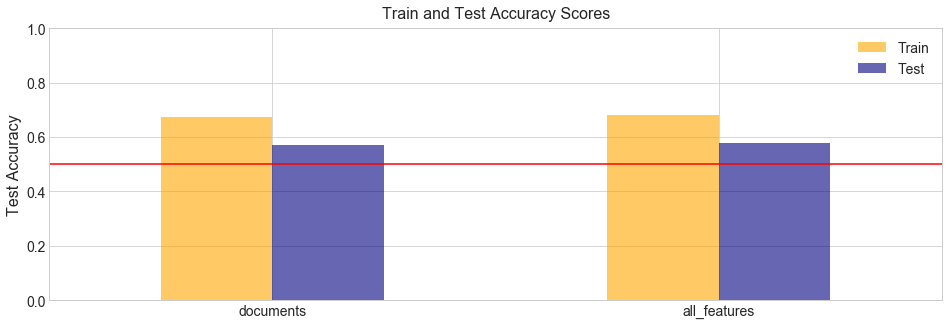

In [53]:
# Create plot fot 'Test Accuracy Scores'
results_df.plot(kind='bar', figsize=(16,5), color=['orange', 'navy'], alpha=.6)

plt.title('Train and Test Accuracy Scores', size=16, pad=10)
plt.axhline(0.5, color='r')
# plt.axhline(0.75, color='b')
# plt.axhline(0.33, color='y', )
plt.ylabel('Test Accuracy', size=16)
plt.xticks([0,1], ['documents', 'all_features'],size=14, rotation=0)
plt.yticks(size=14)
plt.ylim(0, 1)
plt.legend(prop={'size': 14});

### 5.9 - Feature Importance

In [43]:
feature_importance = pd.concat([pd.DataFrame(df.drop(columns=['company', 'release_date', 'security',
                                         'stock_change', 'index_change',
                                         'normalized_change', 'movement', 'target']).columns),
                     pd.DataFrame(np.transpose(logreg_all.named_steps['logreg'].coef_),
                        columns=['down','neutral','up'])], axis = 1).dropna()

feature_importance.rename(columns={0:'features'}, inplace=True)
feature_importance.set_index('features', inplace=True)

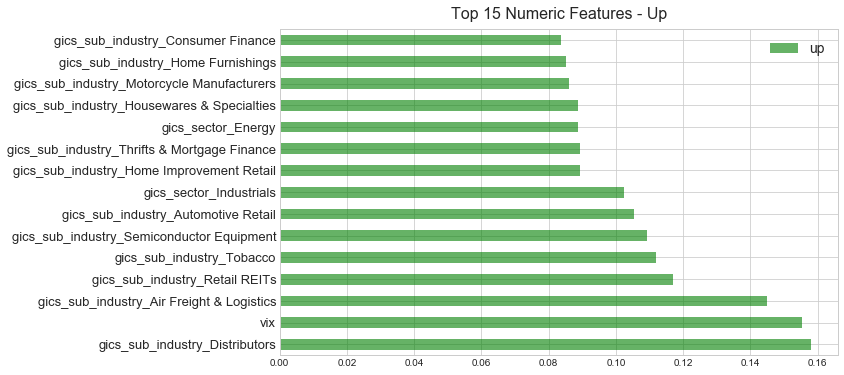

In [44]:
feature_importance.sort_values('up', ascending=False)[['up']].head(15).plot(kind='barh',
                                                                            figsize=(10,6),
                                                                            color='g',
                                                                            alpha=.6)
plt.ylabel('')
plt.yticks(size=13)
plt.legend(prop={'size': 14})
plt.title('Top 15 Numeric Features - Up', size=16, pad=10);

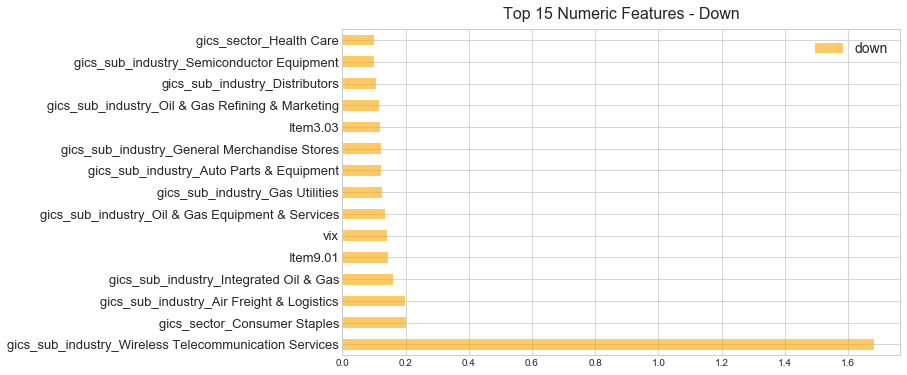

In [45]:
feature_importance.sort_values('down', ascending=False)[['down']].head(15).plot(kind='barh',
                                                                            figsize=(10,6),
                                                                            color='orange',
                                                                            alpha=.6)
plt.ylabel('')
plt.yticks(size=13)
plt.legend(prop={'size': 14})
plt.title('Top 15 Numeric Features - Down', size=16, pad=10);

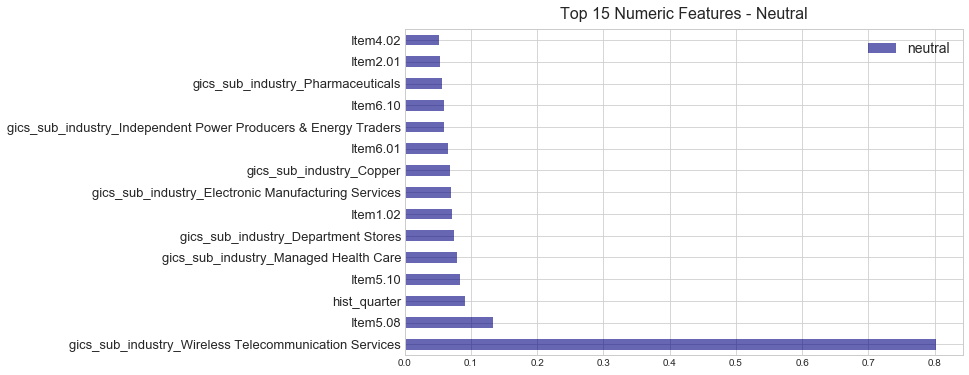

In [46]:
feature_importance.sort_values('neutral', ascending=False)[['neutral']].head(15).plot(kind='barh',
                                                                            figsize=(10,6),
                                                                            color='navy',
                                                                            alpha=.6)
plt.ylabel('')
plt.yticks(size=13)
plt.legend(prop={'size': 14})
plt.title('Top 15 Numeric Features - Neutral', size=16, pad=10);

### 5.10 - Most Frequent Words

In [47]:
# Use Porter Stemmer to Tokenize and Get Most Common Words
tfidf = TfidfVectorizer(max_features=3500,
                        ngram_range=(1,1),
                        max_df=0.98,
                        min_df=1)

sparse_tfidf = tfidf.fit_transform(X_test['processed_text'])

sparse_tfidf_df = pd.DataFrame(sparse_tfidf.toarray(), columns=tfidf.get_feature_names())

sparse_tfidf_df['preds'] = logreg_all.predict(X_test)

In [48]:
# Vegetarian Most Common words (Top 10)
words_down = pd.DataFrame(sparse_tfidf_df.loc[sparse_tfidf_df['preds']==0, :] \
                                .sum().sort_values(ascending=False), columns=['word_count'])[:10]

In [49]:
words_neutral = pd.DataFrame(sparse_tfidf_df.loc[sparse_tfidf_df['preds']==1, :] \
                                .sum().sort_values(ascending=False), columns=['word_count'])[1:11]

In [50]:
words_up = pd.DataFrame(sparse_tfidf_df.loc[sparse_tfidf_df['preds']==2, :] \
                                .sum().sort_values(ascending=False), columns=['word_count'])[1:11]

In [51]:
words_up[:1]

,word_count
net,208.995637


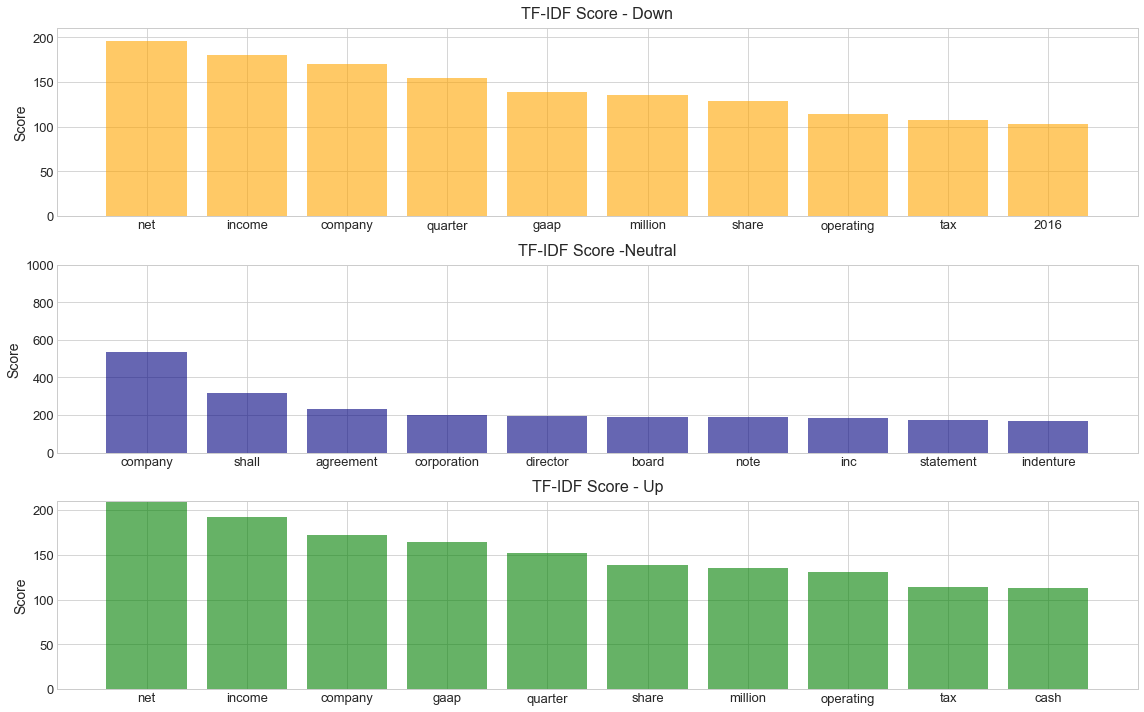

In [52]:
# Plot Most Common Words
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

axes[0].bar(words_down.index, height=words_down['word_count'], color='orange', alpha=0.6)
axes[0].set_title('TF-IDF Score - Down', size=16, pad=10)
axes[0].set_ylabel('Score', size=14)
axes[0].tick_params(labelsize=13)
axes[0].set_ylim(0,210)

axes[1].bar(words_neutral.index, height=words_neutral['word_count'], color='navy', alpha=0.6)
axes[1].set_title('TF-IDF Score -Neutral', size=16, pad=10)
axes[1].set_ylabel('Score', size=14)
axes[1].tick_params(labelsize=13)
axes[1].set_ylim(0,1000)

axes[2].bar(words_up.index, height=words_up['word_count'], color='g', alpha=0.6)
axes[2].set_title('TF-IDF Score - Up', size=16, pad=10)
axes[2].set_ylabel('Score', size=14)
axes[2].tick_params(labelsize=13)
axes[2].set_ylim(0,210)
plt.tight_layout()